# Run Harmonic Regression Using Tesseract

<img src="img/seerai_logo.png" width=505/><img src="img/tesseract.png"/>

This demo will show how SeerAI's platform (Geodesic) can make a complex data analysis workflow much easier, faster (and less costly) without having to move large data sets with our innovative computation engine (Tesseract). The source data (Landsat satellite) is located on Google Earth Engine and we will use our Boson tool to point to that repository and establish a reference to the data in Geodesic's Knowledge Graph. With that reference to the data stored in our graph, the knowledge of where that data sits, how to get to it at the right time, and what it is useful for is all now ready for the model to use. This demo shows how this will allow the Tesseract Computation Engine to reach out and gather the data, then process it at scale, with speed that is many times faster than current geospatial tools allow.

<img src="img/graph.png" width=800/>

To demonstrate Tesseract we perform a harmonic regression which is a type of time series analysis that is commonly used in forestry and agriculture. It looks for temporal paterns that repeat over a well defined time interval, in this case yearly. Harmonic regression can be used to understand the trends in certain patterns of spectral data as well as predict out into the future for use in vegetation management, forest health and land cover modeling. This technique is commonly used by the US Forest Service in order to understand the health and seasonal changes of forest inventories. While most often used for vegetation, harmonic regression can be used for modeling any kind of temporal patter that repeats in regular intervals.

In this example we will fit a Fourier series to Landsat-8 data using the Geodesic Platform. The Landsat data is located on Google Earth Engine and we will use a boson to add it to the Geodesic Knowledge Graph which will allow the Tesseract Computation Engine to reach out and gather the data, then process it at scale. In the modeling step we first transform the first 6 spectral bands of Landsat data with the Tasseled Cap Transformaion (TCT). This takes the spectral bands and extracts 3 new bands from them called brightness, greenness, and wetness. We then fit an n-th order Fourier Series to the transormed data. The parameters we are looking for are the coefficients of the following series:

$$ A_{i} = 1 + t_i + \sum\limits_{k=1}^{n} \sin(\frac{2\pi k t_i}{P}) +  \sum\limits_{k=1}^{n} \cos(\frac{2\pi k t_i}{P})  $$

An example of this type of fit can be seen below. This is a simple Sine function with a linear term that has a 4th order Fourier series fit using the least squares regression method.

![simple fit](img/simple-fit.png)

In reality the data is much messier than this nice Sine function. Landsat data can have clouds, bad pixels and even completely missing data. Below is an example of a Fourier series fit to this noisy, unfiltered Landsat data.

![Landsat fit](img/Landsat-fit.png)

### 5 Years of Landsat Data

This shows a fit over about 5 years of Landsat data but only for a single pixel. In practice you must fit a series for every pixel in the area and store all of the parameters as a multidimensional array of data. This is where Tesseract comes in. Tesseract allows us to gather the data, split it into chunks, then efficiently process each of the chunks. Because Tesseract treats time as a first class citizen, we are able to accomidate many kinds of spatial, temporal and spatio-temporal analytics easily. In this analysis we perform more than 2.2 million fits across 200 time steps.

![](img/time-fit.png)


In [10]:
import geodesic
import geodesic.tesseract as T
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
proj = geodesic.set_active_project("har-reg")

## Add the Landsat Dataset to Geodesic

Geodesic operates on a decentralized data model. This allows us to bring in virtually any spatio-temporal dataset from many different sources and transparently use them in the rest of the platform. In this case we are tapping into the multi hundred petabyte catalogue that is maintained by Google Earth Engine. Adding a dataset to the Geodesic Knowledge Graph is a simple matter and just requires a few pieces of information.

In [ ]:
landsat = geodesic.Dataset.from_google_earth_engine(
    name='landsat-8',
    asset='LANDSAT/LC08/C02/T1_L2',
    credential='gee-service-account',
    alias='Landsat 8 Surface Reflectance',
    domain='earth-bservation',
    category='satellite',
    type='electro-optical',
)
landsat.save()

In [3]:
landsat = geodesic.get_dataset("landsat-8")
print(landsat)

dataset:earth-bservation:satellite:electro-optical:landsat-8


## Get Spatial and Temporal Extents for Job

This runs the job for a section of Southern Minnesota. It uses 200 time bins with an 8 day widow giving us approximately 5 years of Landsat data.

In [4]:
bbox = (-94.691162,44.414164,-94.218750,44.676466) # Southern Minnesota
n_timebins = 200
end_date = datetime(2023, 10, 1)
start_date = end_date - n_timebins*timedelta(days=8)
start_date

datetime.datetime(2019, 5, 15, 0, 0)

## Setup the Tesseract Job

Tesseract jobs are specified either with the Python API (as in below) or with JSON. At the root of the job description is basic information such as the jobs name and the spatial extent that should be run over.

In [5]:
job = T.Job(
    name="har-reg-demo-full",
    alias="Harmonic Regression Demo",
    description="Demo of harmonic regression model",
    project=proj,
    bbox=bbox,
    bbox_epsg=4326,
    output_epsg=3857,
)

## Create Input Asset For Job

This creates the input asset from landsat data that is stored on Google Earth Engine. We specify how we would like for this step to output the data. In this case we are requesting the first 6 spectral bands (used for tasseled cap transformation). We must also tell Tesseract how much historical data to gather and how to time bin it. In this case we are telling it to get 200 time bins each with a width of 8 days since Landsat has (approximately) and 8 day revisit time. We also specify how many workers we would like Tesseract to use to gather this data.

The output of this step will be used as the input in the following step where we will run a model.

In [6]:
job.add_create_assets_step(
    name="add-landsat",
    asset_name="landsat",
    dataset="landsat-8",
    dataset_project=proj,
    asset_bands=[
        {"asset": "SR_B2", "bands": [0]},
        {"asset": "SR_B3", "bands": [0]},
        {"asset": "SR_B4", "bands": [0]},
        {"asset": "SR_B5", "bands": [0]},
        {"asset": "SR_B6", "bands": [0]},
        {"asset": "SR_B7", "bands": [0]},
    ],
    output_time_bins=dict(
        strided=T.StridedBinning(
            from_selection=T.BinSelection(datetime=start_date),
            from_end=True,
            duration="8D",
            stride="8D",
            count=n_timebins
        )
    ),
    output_bands=["blue", "green", "red", "nir", "swir1", "swir2"],
    chip_size=512,
    pixel_dtype=np.uint16,
    pixels_options=dict(
        pixel_size=(30.0, 30.0),
    ),
    fill_value=0.0,
    workers=20,
);

## Define the Harmonic Regression Model Step

Here we define how we would like tesseract to run our model. We first specify which docker image to use. This image wraps our model in with the Tesseract SDK, the details of which are in `harmonic_regression.py`.

After the docker image, you need to specify the inputs and outputs for the model. In this case the input is just the output from the previous step (given by the `asset_name` field) and the output is a list of tensors, or arrays that will be output by the model. Because we are doing a harmonic regression on tasseled cap transformations (TCT), we are outputting 3 assets, one for each TCT band. Each output asset also has 10 bands of data. These are the 10 parameters in a 4th order Fourier series.

In [7]:
job.add_model_step(
    name="run-har-reg",
    container=T.Container(
        repository="us-central1-docker.pkg.dev/double-catfish-291717/seerai-docker/images/",
        image="har-reg",
        tag="v0.0.7",
        args={"forder": 4}
    ),
    inputs=[T.StepInput(
        asset_name="landsat",
        dataset_project=proj,
        spatial_chunk_shape=(512, 512),
        type="tensor",
        time_bin_selection=T.BinSelection(all=True),
    )],
    outputs=[
        T.StepOutput(
            asset_name="brightness-params",
            chunk_shape=(1, 10, 512, 512),
            type="tensor",
            pixel_dtype="<f8",
            fill_value="nan",
        ),
        T.StepOutput(
            asset_name="greenness-params",
            chunk_shape=(1, 10, 512, 512),
            type="tensor",
            pixel_dtype="<f8",
            fill_value="nan",
        ),
        T.StepOutput(
            asset_name="wetness-params",
            chunk_shape=(1, 10, 512, 512),
            type="tensor",
            pixel_dtype="<f8",
            fill_value="nan",
        )
    ],
    workers=10
);

## Submit the Job

In [8]:
res = job.submit(dry_run=False)

/home/rob/miniconda3/envs/har-reg/lib/python3.8/site-packages/geodesic/descriptors.py:102: UserWarning: field global_properties is deprecated and will be removed in a future version
  warnings.warn(
/home/rob/miniconda3/envs/har-reg/lib/python3.8/site-packages/geodesic/tesseract/components.py:767: UserWarning: Input Validation Warning (severity=WARN_LOW): resample not set on pixels options, defaulting to resample nearest (output 0 of step add-landsat)
  warnings.warn(f"{self.title} (severity={self.severity}): {self.detail}")


{'job_id': '453e5e8de1ac3889994c1a4c8bca5bf0d743a28f',
 'dataset': dataset:*:*:*:har-reg-demo-full,
 'stac_item': {'type': 'Feature',
  'id': '0',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-94.691162, 44.414164],
     [-94.21875, 44.414164],
     [-94.21875, 44.676466],
     [-94.691162, 44.676466],
     [-94.691162, 44.414164]]]},
  'properties': {'proj:epsg': 3857},
  'links': [{'href': 'https://api.geodesic.seerai.space/tesseract/api/v1/jobs/453e5e8de1ac3889994c1a4c8bca5bf0d743a28f/items/0',
    'rel': 'self',
    'type': 'application/json',
    'title': 'item'},
   {'href': 'https://api.geodesic.seerai.space/tesseract/api/v1/jobs/453e5e8de1ac3889994c1a4c8bca5bf0d743a28f/dataset',
    'rel': 'collection',
    'type': 'application/json',
    'title': 'dataset'},
   {'href': 'https://api.geodesic.seerai.space/tesseract/api/v1/jobs/453e5e8de1ac3889994c1a4c8bca5bf0d743a28f',
    'rel': 'parent',
    'type': 'application/json',
    'title': 'job'}],
  'extensions': ['proj'],

## Watch the Job Complete Using the Widget

In [9]:
job.watch()

## Check the Output of the Job

It is common in the literature to plot an RGB image where each color corresponds to a particular harmonic of the TCT bands. In this case we will just grab each of the parameters for the TCT bands and plot the 4th coefficients. In this case the color channels are (R) Brightness, (G) Greenenss, and (B) Wetness.

In [17]:
brightness = job.zarr('brightness-params')['tesseract']
greenness = job.zarr('greenness-params')['tesseract']
wetness = job.zarr('wetness-params')['tesseract']

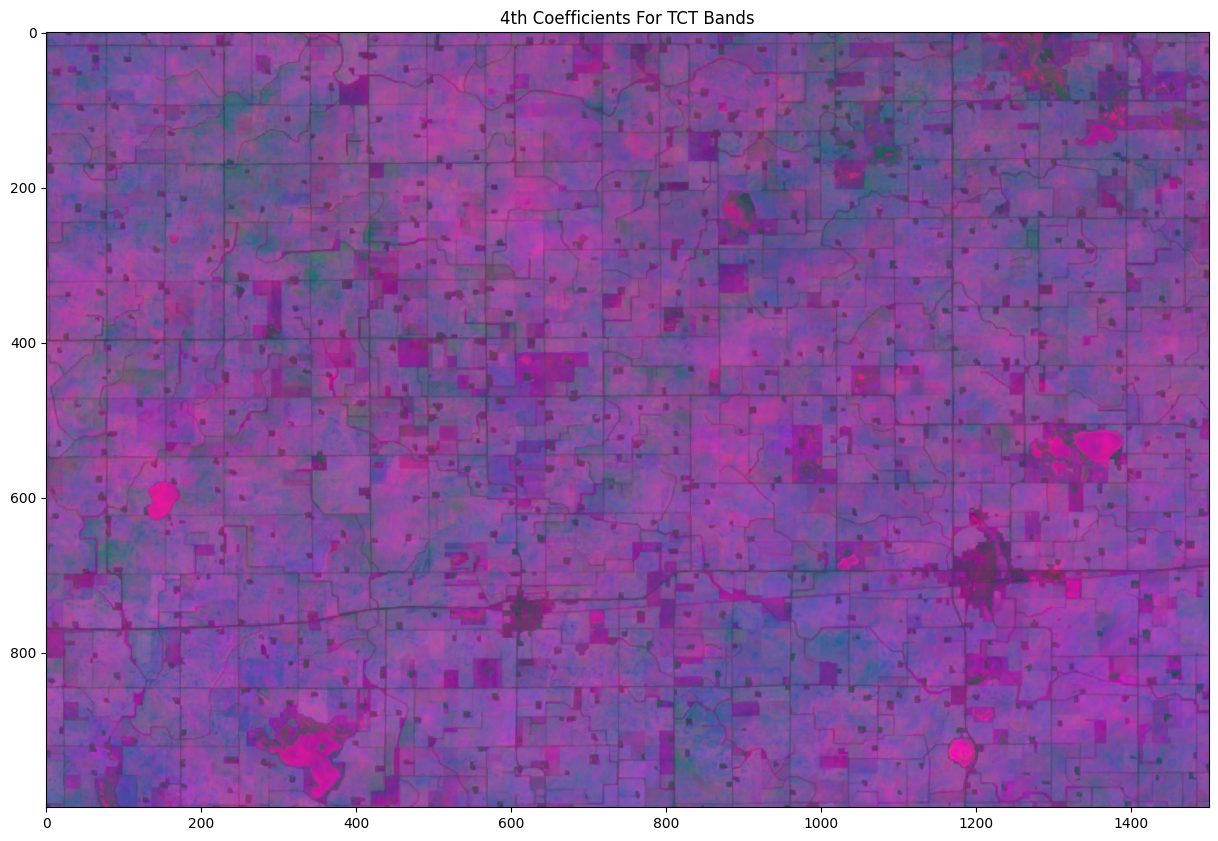

In [22]:
harmonic = 4
img_arr = np.array((brightness[0,harmonic,:,:], greenness[0, harmonic, :, :], wetness[0,harmonic,:,:]))[:, :1000, :1500]
img_arr = (img_arr-img_arr.min())/(img_arr.max() - img_arr.min())
fig= plt.figure(figsize=(1.5*10,1.5*15))
plt.title("4th Coefficients For TCT Bands")
plt.imshow(np.moveaxis(img_arr[0:1000, 0:1500], 0, -1))